# Detecção de Malware Android




## Pré-processamento de dados

### Importações de módulos necessários

In [1]:
# Necessária apenas no jupyter
%matplotlib inline

# Importa os pacotes necessários
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# from google.colab import files

In [2]:
# Redefinine a configuração padrão do pandas para visualização de dados
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Análise do primeiro dataset (Drebin-215)

In [3]:
drebin_df = pd.read_csv('https://raw.githubusercontent.com/lucaspeferreira/trabalho-ii-ia-ppgeec/main/Drebin-215-Original.csv')

drebin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15036 entries, 0 to 15035
Columns: 216 entries, transact to class
dtypes: int64(214), object(2)
memory usage: 24.8+ MB
C:\Users\Lucas Ferreira\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3169: DtypeWarning: Columns (92) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
# Converte os valores das colunas para numérico
drebin_df['READ_EXTERNAL_STORAGE'] = pd.to_numeric(drebin_df['READ_EXTERNAL_STORAGE'])

drebin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15036 entries, 0 to 15035
Columns: 216 entries, transact to class
dtypes: int64(214), object(2)
memory usage: 24.8+ MB


In [5]:
def check_missing_data(df):
    
    total_instances = df.shape[0]
    columns = df.columns

    for column in columns:
        one_zero_count = df[(df[column]==0) | (df[column]==1)].shape[0]
        if one_zero_count != total_instances:
            print('A coluna', column, 'tem', (total_instances-one_zero_count), 'linhas.')

In [6]:
check_missing_data(drebin_df)

A coluna TelephonyManager.getSimCountryIso tem 8192 linhas.
A coluna class tem 15036 linhas.


In [7]:
drebin_df['TelephonyManager.getSimCountryIso'].unique()

array(['0', '1', '?', 1, 0], dtype=object)

In [8]:
drebin_df[(drebin_df['TelephonyManager.getSimCountryIso']=='?')].shape[0]

5

É necessário remover destas duas colunas as instâncias com '?' (Apenas 5) e converter '0' para 0 e '1' para 1.

In [9]:
# Remove as linhas com 'TelephonyManager.getSimCountryIso' = '?'
drebin_df = drebin_df[drebin_df['TelephonyManager.getSimCountryIso']!='?']

In [10]:
drebin_df['TelephonyManager.getSimCountryIso'].unique()

array(['0', '1', 1, 0], dtype=object)

In [11]:
# Converte os valores das colunas para numéricos
drebin_df['TelephonyManager.getSimCountryIso'] = pd.to_numeric(drebin_df['TelephonyManager.getSimCountryIso'])

In [12]:
check_missing_data(drebin_df)

A coluna class tem 15031 linhas.


In [13]:
drebin_df.shape

(15031, 216)

In [14]:
drebin_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15031 entries, 0 to 15035
Columns: 216 entries, transact to class
dtypes: int64(215), object(1)
memory usage: 24.9+ MB


In [15]:
class_freq = drebin_df['class'].value_counts()
class_freq

B    9476
S    5555
Name: class, dtype: int64

### Análise do segundo dataset (Malgenome-215)

In [16]:
malgenome_df = pd.read_csv('https://raw.githubusercontent.com/lucaspeferreira/trabalho-ii-ia-ppgeec/main/Malgenome-215-Original.csv')

In [17]:
malgenome_df.shape

(3799, 216)

In [18]:
malgenome_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3799 entries, 0 to 3798
Columns: 216 entries, transact to class
dtypes: int64(215), object(1)
memory usage: 6.3+ MB


In [19]:
check_missing_data(malgenome_df)

A coluna class tem 3799 linhas.


In [20]:
class_freq = malgenome_df['class'].value_counts()
class_freq

B    2539
S    1260
Name: class, dtype: int64

### Combinando os dois datasets

In [21]:
# Verifica se as colunas em ambos os datasets são as mesmas
drebin_columns_set = set(drebin_df.columns)
malgenome_columns_set = set(malgenome_df.columns)

In [22]:
all_columns = drebin_columns_set.union(malgenome_columns_set)
len(all_columns)

223

In [23]:
common_columns = drebin_columns_set.intersection(malgenome_columns_set)
len(common_columns)

209

In [24]:
not_common_columns = drebin_columns_set.symmetric_difference(malgenome_columns_set)
len(not_common_columns)

14

Dentre os dois datasets, há 209 features em comum ('common_columns'). Foi necessário remover as colunas extras do dataset ('not_common_columns'). 

In [25]:
not_common_columns

{'.system.app',
 '.system.bin',
 '/system/app',
 '/system/bin',
 'BIND_TEXT_SERVICE',
 'BROADCAST_PACKAGE_REMOVED',
 'CONTROL_LOCATION_UPDATES',
 'DELETE_CACHE_FILES',
 'HARDWARE_TEST',
 'INJECT_EVENTS',
 'READ_INPUT_STATE',
 'Runtime.loadLibrary',
 'android.intent.action.CAMERA_BUTTON',
 'android.intent.action.REBOOT'}

In [26]:
drebin_drop_columns = [] 
malgenome_drop_columns = []

for drop_column in not_common_columns:
    if(drop_column in drebin_df.columns):
        drebin_drop_columns.append(drop_column)
    if(drop_column in malgenome_df.columns):
        malgenome_drop_columns.append(drop_column)

In [27]:
drebin_drop_columns

['HARDWARE_TEST',
 'CONTROL_LOCATION_UPDATES',
 '/system/bin',
 'DELETE_CACHE_FILES',
 '/system/app',
 'BIND_TEXT_SERVICE',
 'Runtime.loadLibrary']

In [28]:
# Remove as colunas 'drebin_drop_clumns' do dataset 'drebin_df'
for drop_column in drebin_drop_columns:
    drebin_df = drebin_df.drop(columns=[drop_column])

In [29]:
malgenome_drop_columns

['.system.app',
 '.system.bin',
 'android.intent.action.REBOOT',
 'android.intent.action.CAMERA_BUTTON',
 'BROADCAST_PACKAGE_REMOVED',
 'READ_INPUT_STATE',
 'INJECT_EVENTS']

In [30]:
# Remove as colunas 'malgenome_drop_clumns' do dataset 'malgenome_df'
for drop_column in malgenome_drop_columns:
    malgenome_df = malgenome_df.drop(columns=[drop_column])

In [31]:
# Verifica se as colunas de ambos os datasets são as mesmas
drebin_columns_set = set(drebin_df.columns)
malgenome_columns_set = set(malgenome_df.columns)

In [32]:
common_columns = drebin_columns_set.intersection(malgenome_columns_set)
print(len(common_columns) , drebin_df.columns.shape[0], malgenome_df.columns.shape[0])

209 209 209


In [33]:
not_common_columns = drebin_columns_set.symmetric_difference(malgenome_columns_set)
len(not_common_columns)

0

In [34]:
# Combina os dois datasets
merged_df = pd.concat([drebin_df, malgenome_df], ignore_index=True)

In [35]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18830 entries, 0 to 18829
Columns: 209 entries, transact to class
dtypes: int64(208), object(1)
memory usage: 30.0+ MB


In [36]:
check_missing_data(merged_df)

A coluna class tem 18830 linhas.


### Dividindo o dataset em treino/teste (holdout)



In [37]:
from sklearn.model_selection import train_test_split

X_all = merged_df.drop(columns='class')
y_all = merged_df['class']

X, X_holdout, y, y_holdout = train_test_split(X_all, y_all, test_size=0.3, random_state=42, stratify=y_all)

# Concatena os datasets de teste e de holdout
experimenting_df = pd.concat([X, y], axis=1).reset_index(drop=True)
holdout_df = pd.concat([X_holdout, y_holdout], axis=1).reset_index(drop=True)

In [38]:
experimenting_df['class'].value_counts()

B    8410
S    4771
Name: class, dtype: int64

In [39]:
holdout_df['class'].value_counts()

B    3605
S    2044
Name: class, dtype: int64

In [40]:
experimenting_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13181 entries, 0 to 13180
Columns: 209 entries, transact to class
dtypes: int64(208), object(1)
memory usage: 21.0+ MB


In [41]:
holdout_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5649 entries, 0 to 5648
Columns: 209 entries, transact to class
dtypes: int64(208), object(1)
memory usage: 9.0+ MB


### Salvando os datasets pré-processados

In [42]:
drebin_df['class'] = drebin_df['class'].map({'B': 0, 'S': 1})
malgenome_df['class'] = malgenome_df['class'].map({'B': 0, 'S': 1})
merged_df['class'] = merged_df['class'].map({'B': 0, 'S': 1})
experimenting_df['class'] = experimenting_df['class'].map({'B': 0, 'S': 1})
holdout_df['class'] = holdout_df['class'].map({'B': 0, 'S': 1})

In [43]:
experimenting_df['class'].value_counts()

0    8410
1    4771
Name: class, dtype: int64

In [44]:
holdout_df['class'].value_counts()

0    3605
1    2044
Name: class, dtype: int64

In [45]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18830 entries, 0 to 18829
Columns: 209 entries, transact to class
dtypes: int64(209)
memory usage: 30.0 MB


In [46]:
# Salva os datasets pré-processados em novos arquivos CSV
drebin_df.to_csv('Drebin.csv', index=False)
malgenome_df.to_csv('Malgenome.csv', index=False)
merged_df.to_csv('Drebin-Malgenome.csv', index=False)

# Dataset de treino (70%)
experimenting_df.to_csv('Drebin-Malgenome-Train-70.csv', index=False)

# Dataset de teste (30%)
holdout_df.to_csv('Drebin-Malgenome-Test-30.csv', index=False)

In [47]:
# Faz o download dos datasets pré processados (opcional)
# files.download('Drebin.csv')
# files.download('Malgenome.csv')
# files.download('Drebin_Malgenome.csv')
# files.download('Drebin-Malgenome-Train-70.csv')
# files.download('Drebin-Malgenome-Test-30.csv')

## Seleção de features

### Seleção das features no dataset de treino

Utilizando o software Weka e o classificador CfsSubsetEval com BestFirst/GreedyStepwise, foi possível extrair 27 features dentre todas as disponíveis. 

In [48]:
selected_features_weka = ['transact', 'onServiceConnected', 'bindService', 'attachInterface', 'SEND_SMS', 
                          'Ljava.lang.Class.getCanonicalName', 'Ljava.lang.Class.getMethods', 'Ljava.net.URLDecoder', 
                          'android.telephony.SmsManager', 'READ_PHONE_STATE', 'getBinder', 'GET_ACCOUNTS', 
                          'RECEIVE_SMS', 'READ_SMS', 'getCallingUid', 'android.intent.action.BOOT_COMPLETED', 
                          'USE_CREDENTIALS', 'TelephonyManager.getLine1Number', 'android.intent.action.SEND', 
                          'android.telephony.gsm.SmsManager', 'WRITE_HISTORY_BOOKMARKS', 
                          'TelephonyManager.getSubscriberId', 'INSTALL_PACKAGES', 'createSubprocess', 
                          'ACCESS_LOCATION_EXTRA_COMMANDS', 'MASTER_CLEAR', 'BIND_INPUT_METHOD', 
                          'class']

len(selected_features_weka)

28

In [49]:
malware_df = pd.read_csv('https://raw.githubusercontent.com/lucaspeferreira/data-dataset/main/Drebin-Malgenome-Train-70.csv')

malware_df.shape

(13181, 209)

In [50]:
# Mantem apenas as features selecionadas no dataframe
malware_weka_features_df = malware_df.copy()

kept_columns_cnt = 0
for column in malware_df.columns:
    if column in selected_features_weka:
        kept_columns_cnt+=1
    else:
        malware_weka_features_df = malware_weka_features_df.drop(columns=[column])
        
print(kept_columns_cnt, 'colunas mantidas.')

28 colunas mantidas.


In [51]:
malware_weka_features_df.shape

(13181, 28)

In [52]:
malware_weka_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13181 entries, 0 to 13180
Data columns (total 28 columns):
 #   Column                                Non-Null Count  Dtype
---  ------                                --------------  -----
 0   transact                              13181 non-null  int64
 1   onServiceConnected                    13181 non-null  int64
 2   bindService                           13181 non-null  int64
 3   attachInterface                       13181 non-null  int64
 4   SEND_SMS                              13181 non-null  int64
 5   Ljava.lang.Class.getCanonicalName     13181 non-null  int64
 6   Ljava.lang.Class.getMethods           13181 non-null  int64
 7   Ljava.net.URLDecoder                  13181 non-null  int64
 8   android.telephony.SmsManager          13181 non-null  int64
 9   READ_PHONE_STATE                      13181 non-null  int64
 10  getBinder                             13181 non-null  int64
 11  GET_ACCOUNTS                          131

In [53]:
# Salva o dataset com as features selecionadas
# malware_weka_features_df.to_csv('Drebin-Malgenome-Train-70-Features-Selecionadas.csv', index=False)
# files.download('Drebin-Malgenome-Train-70-Features-Selecionadas.csv')

### Mapa de calor da correlação entre as features

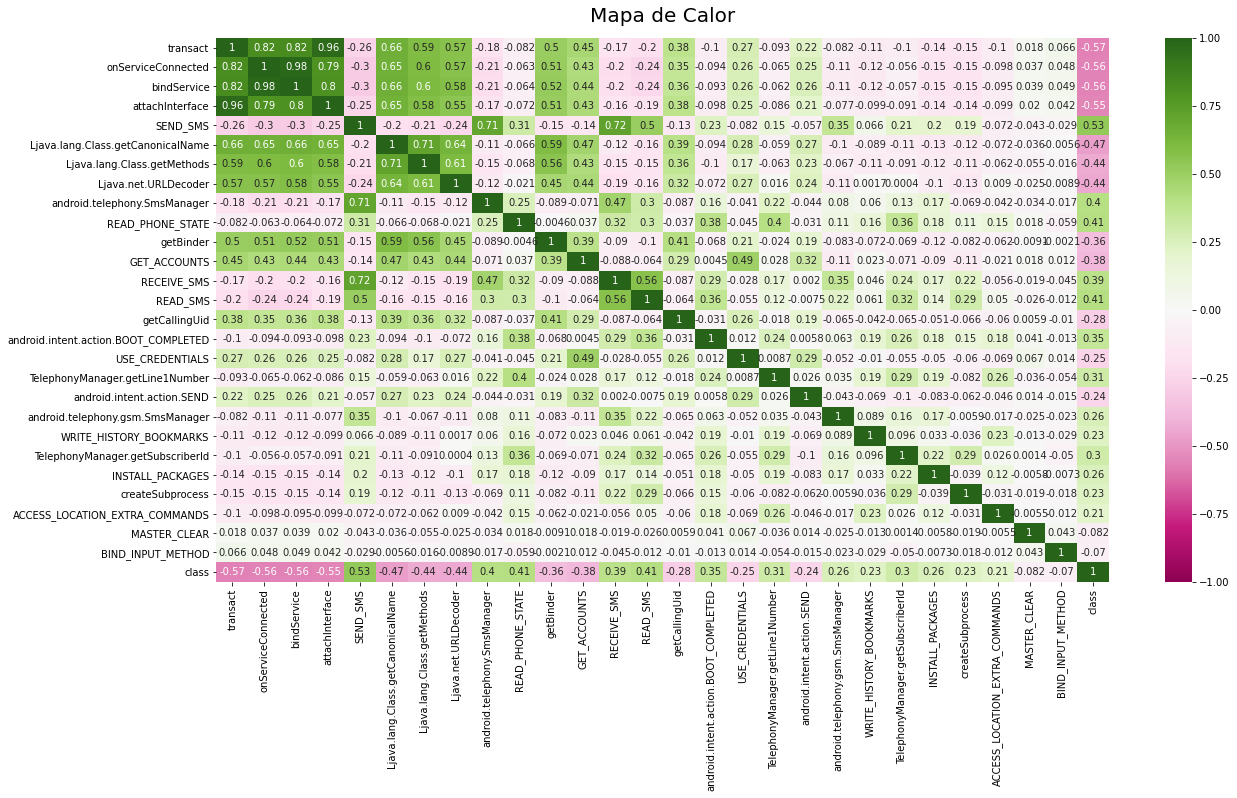

In [54]:
import seaborn

plt.figure(figsize=(20, 10))
corr_matrix = malware_weka_features_df.corr()

# mask to hide the upper triangle of the symmetric corr-matrix
# mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))

heatmap = seaborn.heatmap(
    # correlation matrix
    corr_matrix,

    # mask the top triangle of the matrix
    # mask=mask,
    
    # two-contrast color, different color for + -
    cmap="PiYG",

    # color map range
    vmin=-1, vmax=1,
    
    # show corr values in the cells
    annot=True
)

# set a title
heatmap.set_title('Mapa de Calor', fontdict={'fontsize':20}, pad=16);

plt.show()

### Calculo do valor médio de correlação absoluta de cada feature com a classe destino (medida de ganho de informação)

In [55]:
def get_absolute_corr_with_target(df): 
  columns = df.columns

  corrs = []

  for col in columns:
    if col == 'class':
      continue
    corr_val = abs(df[col].corr(df['class']))
    corrs.append(corr_val) 

  return corrs

In [56]:
# Media e desvio padrão de todas as features
corrs_targetClass_all_features = get_absolute_corr_with_target(malware_df)
print('Mean (media):', round(np.mean(corrs_targetClass_all_features), 3), '\n STD (desvio padrão):', round(np.std(corrs_targetClass_all_features), 3))

Mean (media): 0.146 
 STD (desvio padrão): 0.135


In [57]:
# Media e desvio padrão das features selecionadas
corrs_targetClass_selected_features = get_absolute_corr_with_target(malware_weka_features_df)
print('Mean (media):', round(np.mean(corrs_targetClass_selected_features), 3), '\n STD (desvio padrão):', round(np.std(corrs_targetClass_selected_features), 3))

Mean (media): 0.354 
 STD (desvio padrão): 0.136


Sem a seleção das features, a média dos valores absolutos de correlação é de 0.15. Com a seleção de features, esse valor sobe para 0.35.

### Calcula o valor médio da correlação absoluta de cada uma das features, exceto da classe destino (medida de redundância)

In [58]:
def get_absolute_corr_each_pair(df):
  columns = df.columns
  columns_len = len(columns)

  corrs = []

  for i in range(columns_len):
    if columns[i] == 'class':
      continue

    for j in range(i+1, columns_len):
      if columns[j] == 'class':
        continue
      column1 = columns[i]
      column2 = columns[j]
      if column1==column2:
        continue
      #print(column1, i, column2, j)
      corrs.append(abs(df[column1].corr(df[column2])))

  return (corrs)

In [59]:
corrs_eachPair_all_features = get_absolute_corr_each_pair(malware_df)
print('Mean (media):', round(np.mean(corrs_eachPair_all_features), 3), '\n STD (desvio padrão):', round(np.std(corrs_eachPair_all_features), 3))

Mean (media): 0.086 
 STD (desvio padrão): 0.109


In [60]:
corrs_eachPair_selected_features = get_absolute_corr_each_pair(malware_weka_features_df)
print('Mean (media):', round(np.mean(corrs_eachPair_selected_features), 3), '\n STD (desvio padrão):', round(np.std(corrs_eachPair_selected_features), 3))

Mean (media): 0.177 
 STD (desvio padrão): 0.186


In [61]:
np.mean(corrs_eachPair_selected_features)

0.17705916811546368

### Diagrama de caixa do valor absoluto de correlação com a classe destino e valor absoluto da correlação com cada par para o dataset com todas as features e com as features selecionadas


In [62]:
def setup_box_plot(datalist1, datalist2, datalist1_label = 'data1', datalist2_label = 'data2', color = 'pink'):
    
    box_plot_data = [datalist1, datalist2]
    box_plot_labels = [datalist1_label, datalist2_label]

    # configure the figure size
    fig = plt.figure(figsize =(10,8))
    fig.suptitle('Diagrama de caixa')
    
    box_plot = plt.boxplot(
                    box_plot_data,
                    vert=False,  # horizontal box alignment
                    patch_artist=True,  # fill with color
                    labels=box_plot_labels
                )

    # fill with colors
    colors = [color, color]
    for patch, color in zip(box_plot['boxes'], colors):
            patch.set_facecolor(color)

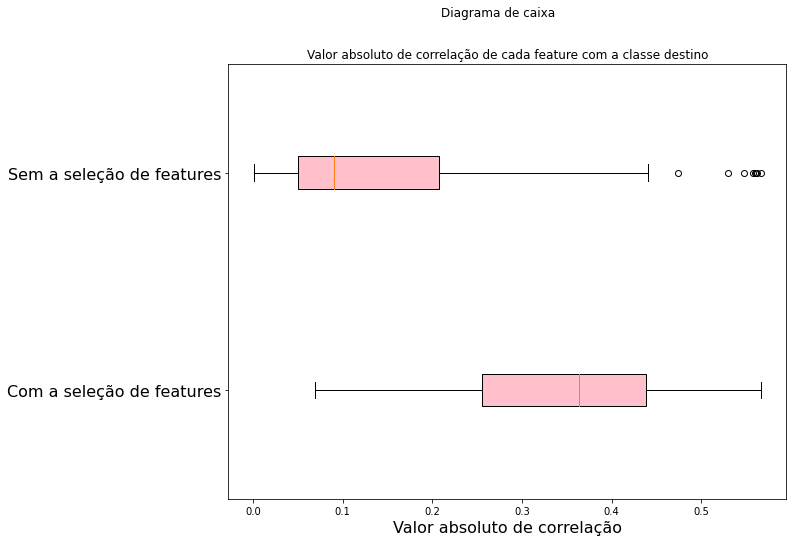

In [63]:
setup_box_plot(corrs_targetClass_selected_features, corrs_targetClass_all_features, 
               datalist1_label = 'Com a seleção de features', datalist2_label = 'Sem a seleção de features')
plt.title('Valor absoluto de correlação de cada feature com a classe destino')
plt.xlabel('Valor absoluto de correlação', fontsize=16)
plt.yticks(fontsize=16)
plt.show()

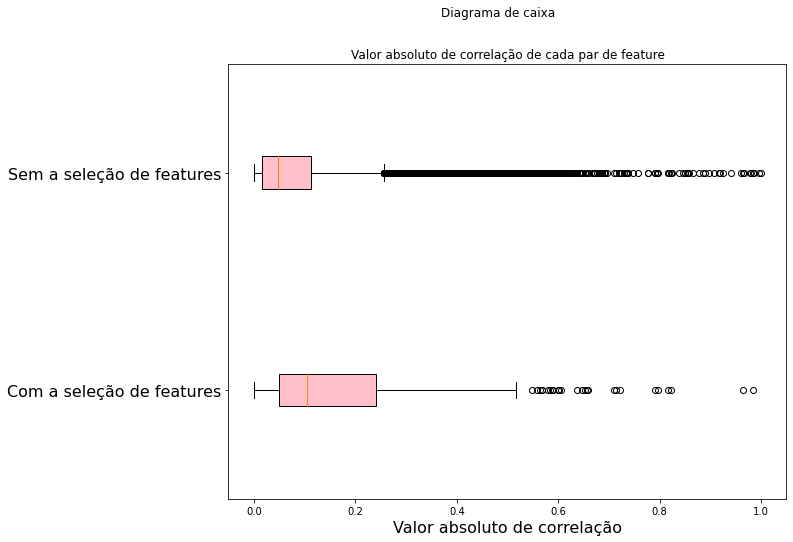

In [64]:
setup_box_plot(corrs_eachPair_selected_features, corrs_eachPair_all_features, datalist1_label = 'Com a seleção de features', datalist2_label = 'Sem a seleção de features')
plt.title('Valor absoluto de correlação de cada par de feature')
plt.xlabel('Valor absoluto de correlação', fontsize=16)
plt.yticks(fontsize=16)
plt.show()

### Seleção das features no dataset de testes (holdout)

In [65]:
holdout_malware_df = pd.read_csv('https://raw.githubusercontent.com/lucaspeferreira/data-dataset/main/Drebin-Malgenome-Test-30.csv')

holdout_malware_df.shape

(5649, 209)

In [66]:
# Mantem apenas as features selecionadas no dataframe
kept_columns_cnt = 0
for column in malware_df.columns:
    if column in selected_features_weka:
        kept_columns_cnt+=1
    else:
        holdout_malware_df = holdout_malware_df.drop(columns=[column])
        
print(kept_columns_cnt, 'colunas mantidas.')

28 colunas mantidas.


In [67]:
holdout_malware_df.shape

(5649, 28)

In [68]:
# Salva o dataset com as features selecionadas
# holdout_malware_df.to_csv('Drebin-Malgenome-Test-30-Features-Selecionadas.csv', index=False)
# files.download('Drebin-Malgenome-Test-30-Features-Selecionadas.csv')

## Aplicação dos algoritmos de aprendizado de máquina

### Decision Tree


In [69]:
from sklearn.tree import DecisionTreeClassifier

In [70]:
df = pd.read_csv('https://raw.githubusercontent.com/lucaspeferreira/data-dataset/main/Drebin-Malgenome-Train-70-Features-Selecionadas.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13181 entries, 0 to 13180
Data columns (total 28 columns):
 #   Column                                Non-Null Count  Dtype
---  ------                                --------------  -----
 0   transact                              13181 non-null  int64
 1   onServiceConnected                    13181 non-null  int64
 2   bindService                           13181 non-null  int64
 3   attachInterface                       13181 non-null  int64
 4   SEND_SMS                              13181 non-null  int64
 5   Ljava.lang.Class.getCanonicalName     13181 non-null  int64
 6   Ljava.lang.Class.getMethods           13181 non-null  int64
 7   Ljava.net.URLDecoder                  13181 non-null  int64
 8   android.telephony.SmsManager          13181 non-null  int64
 9   READ_PHONE_STATE                      13181 non-null  int64
 10  getBinder                             13181 non-null  int64
 11  GET_ACCOUNTS                          131

In [71]:
X = df.drop('class', axis = 1)
y = df['class']

In [72]:
# Define a hiperparametrização onde a Decision Tree dá a melhor combinação de acurácia, score F1 e curva ROC
from sklearn.model_selection import StratifiedKFold,cross_val_score

cv = StratifiedKFold(n_splits=10, random_state=42, shuffle= True)

max_depth = [x for x in range(1,30)]

accuracies = []
f1s = []
aucs = []
for depth in max_depth:
    model = DecisionTreeClassifier(criterion='gini',max_depth = depth)
    accuracie_segments = cross_val_score(model, X, y, scoring='accuracy',cv=cv, n_jobs=1)
    f1_segments = cross_val_score(model, X, y, scoring='f1',cv=cv, n_jobs=1)
    auc_segments = cross_val_score(model, X, y, scoring='roc_auc',cv=cv, n_jobs=1)
    accuracies.append(np.mean(accuracie_segments))
    f1s.append(np.mean(f1_segments))
    aucs.append(np.mean(auc_segments))

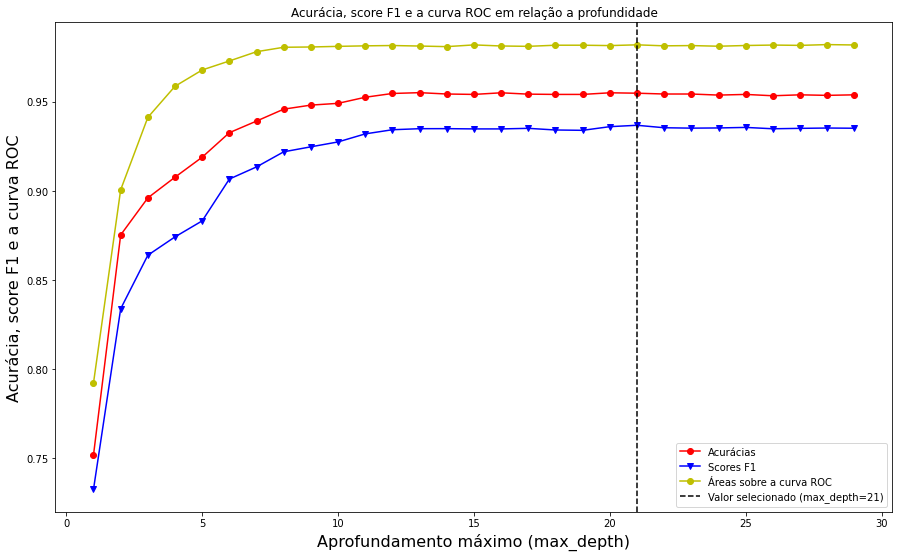

In [73]:
plt.figure(figsize =(15,9))
plt.title('Acurácia, score F1 e a curva ROC em relação a profundidade')
plt.plot(max_depth, accuracies, 'ro-',  max_depth, f1s ,'bv-', max_depth, aucs,'yo-')
plt.axvline(x=21, color='k', linestyle='--')
plt.legend(['Acurácias','Scores F1','Áreas sobre a curva ROC', 'Valor selecionado (max_depth=21)'])
plt.xlabel('Aprofundamento máximo (max_depth)', fontsize=16)
plt.ylabel('Acurácia, score F1 e a curva ROC', fontsize=16)
plt.show()

In [74]:
# <https://towardsdatascience.com/building-a-k-nearest-neighbors-k-nn-model-with-scikit-learn-51209555453a>
# <https://towardsdatascience.com/gridsearchcv-for-beginners-db48a90114ee>

from sklearn.model_selection import GridSearchCV

# Cria o modelo de Decision Tree
decisionTree_model_gscv = DecisionTreeClassifier(random_state=42)

# Cria um dicionario com todos os parâmetros
param_grid = {'max_depth': np.arange(1, 30), 'criterion': ['gini', 'entropy']}
# Usa o gridsearch para checar todos os valores dos parâmetros
decisionTree_gscv = GridSearchCV(decisionTree_model_gscv, param_grid, scoring=['accuracy', 'f1', 'roc_auc'], refit='accuracy', cv=cv)
# Cria o modelo fit para os dados
decisionTree_gscv.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])},
             refit='accuracy', scoring=['accuracy', 'f1', 'roc_auc'])

In [75]:
# Verifica a performance dos parametros encontrados
decisionTree_gscv.best_params_

{'criterion': 'gini', 'max_depth': 21}

In [76]:
decisionTree_gscv.best_score_

0.9551623810285303

O critério Gini com aprofundamento máximo (max_depth) de 21 são os melhores parâmetros a serem utilizados para um melhor desfecho.

In [77]:
# Avaliação do modelo no dataset de treino
y_predict = decisionTree_gscv.predict(X)

In [78]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('Avaliação do dataset de treino')
print('Acurácia:', round(accuracy_score(y, y_predict), 3))
print('Precisão:', round(precision_score(y, y_predict), 3))
print('Recall:', round(recall_score(y, y_predict), 3))
print('Score F1:', round(f1_score(y, y_predict), 3))

Avaliação do dataset de treino
Acurácia: 0.965
Precisão: 0.984
Recall: 0.92
Score F1: 0.951


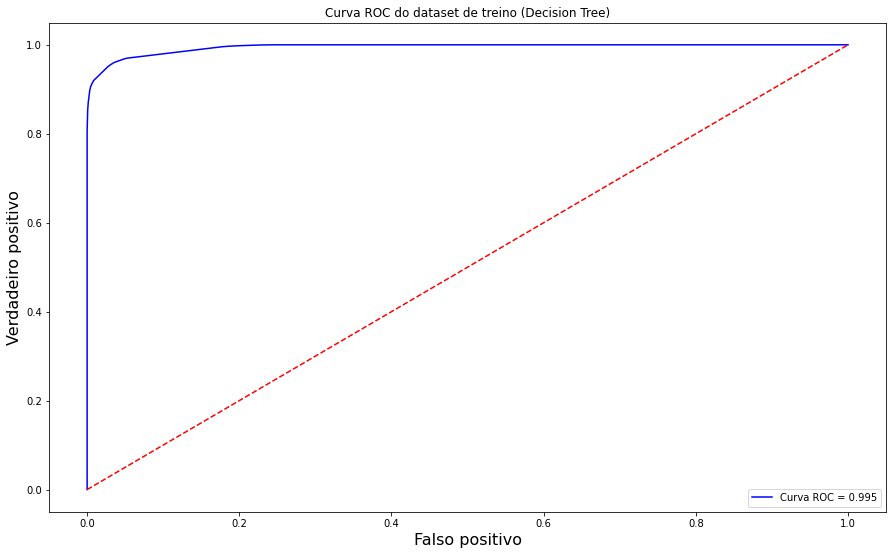

In [79]:
# Área da curva ROC
from sklearn.metrics import roc_curve, roc_auc_score

y_probs = decisionTree_gscv.predict_proba(X)
y_probs = y_probs[:,1]
fpr, tpr, threshold = roc_curve(y, y_probs)
roc_auc = roc_auc_score(y, y_probs)

plt.figure(figsize =(15,9))
plt.title('Curva ROC do dataset de treino (Decision Tree)')
plt.plot(fpr, tpr, 'b', label = 'Curva ROC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('Verdadeiro positivo', fontsize=16)
plt.xlabel('Falso positivo', fontsize=16)
plt.show()

In [80]:
# Avaliação do modelo no dataset de teste
holdout_df = pd.read_csv('https://raw.githubusercontent.com/lucaspeferreira/data-dataset/main/Drebin-Malgenome-Test-30-Features-Selecionadas.csv')
holdout_df.shape

(5649, 28)

In [81]:
holdout_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5649 entries, 0 to 5648
Data columns (total 28 columns):
 #   Column                                Non-Null Count  Dtype
---  ------                                --------------  -----
 0   transact                              5649 non-null   int64
 1   onServiceConnected                    5649 non-null   int64
 2   bindService                           5649 non-null   int64
 3   attachInterface                       5649 non-null   int64
 4   SEND_SMS                              5649 non-null   int64
 5   Ljava.lang.Class.getCanonicalName     5649 non-null   int64
 6   Ljava.lang.Class.getMethods           5649 non-null   int64
 7   Ljava.net.URLDecoder                  5649 non-null   int64
 8   android.telephony.SmsManager          5649 non-null   int64
 9   READ_PHONE_STATE                      5649 non-null   int64
 10  getBinder                             5649 non-null   int64
 11  GET_ACCOUNTS                          5649 

In [82]:
X_holdout = holdout_df.drop('class', axis = 1)
y_holdout = holdout_df['class']

In [83]:
y_holdout_predict = decisionTree_gscv.predict(X_holdout)

In [84]:
print('Avaliação do dataset de teste')
print('Acurácia:', round(accuracy_score(y_holdout, y_holdout_predict), 3))
print('Precisão:', round(precision_score(y_holdout, y_holdout_predict), 3))
print('Recall:', round(recall_score(y_holdout, y_holdout_predict), 3))
print('Score F1:', round(f1_score(y_holdout, y_holdout_predict), 3))

Avaliação do dataset de teste
Acurácia: 0.959
Precisão: 0.965
Recall: 0.921
Score F1: 0.943


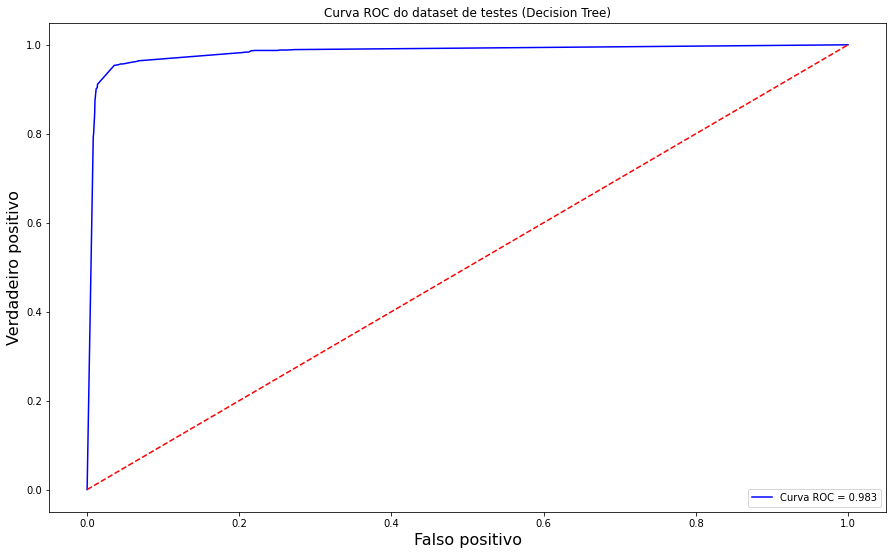

In [85]:
from sklearn.metrics import roc_curve, roc_auc_score

y_holdout_probs = decisionTree_gscv.predict_proba(X_holdout)
y_holdout_probs = y_holdout_probs[:,1]
fpr, tpr, threshold = roc_curve(y_holdout, y_holdout_probs)
roc_auc = roc_auc_score(y_holdout, y_holdout_probs)

plt.figure(figsize =(15,9))
plt.title('Curva ROC do dataset de testes (Decision Tree)')
plt.plot(fpr, tpr, 'b', label = 'Curva ROC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('Verdadeiro positivo', fontsize=16)
plt.xlabel('Falso positivo', fontsize=16)
plt.show()

### K-Nearnest Neighbour


In [86]:
from sklearn.neighbors import KNeighborsClassifier

In [87]:
df = pd.read_csv('https://raw.githubusercontent.com/lucaspeferreira/data-dataset/main/Drebin-Malgenome-Train-70-Features-Selecionadas.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13181 entries, 0 to 13180
Data columns (total 28 columns):
 #   Column                                Non-Null Count  Dtype
---  ------                                --------------  -----
 0   transact                              13181 non-null  int64
 1   onServiceConnected                    13181 non-null  int64
 2   bindService                           13181 non-null  int64
 3   attachInterface                       13181 non-null  int64
 4   SEND_SMS                              13181 non-null  int64
 5   Ljava.lang.Class.getCanonicalName     13181 non-null  int64
 6   Ljava.lang.Class.getMethods           13181 non-null  int64
 7   Ljava.net.URLDecoder                  13181 non-null  int64
 8   android.telephony.SmsManager          13181 non-null  int64
 9   READ_PHONE_STATE                      13181 non-null  int64
 10  getBinder                             13181 non-null  int64
 11  GET_ACCOUNTS                          131

In [88]:
X = df.drop('class', axis = 1)
y = df['class']

In [89]:
# Define a hiperparametrização onde o K-Nearnest Neighbour dá a melhor combinação de acurácia, score F1 e curva ROC
from sklearn.model_selection import StratifiedKFold,cross_val_score

cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

num_of_neigbors = [x for x in range(1,30)]

accuracies = []
f1s = []
aucs = []
for k in num_of_neigbors:
    model = KNeighborsClassifier(n_neighbors=k,metric='minkowski', p=2)
    accuracy_segments = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=1)
    f1_segments = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=1)
    auc_segments = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=1)
    accuracies.append(np.mean(accuracy_segments))
    f1s.append(np.mean(f1_segments))
    aucs.append(np.mean(auc_segments))

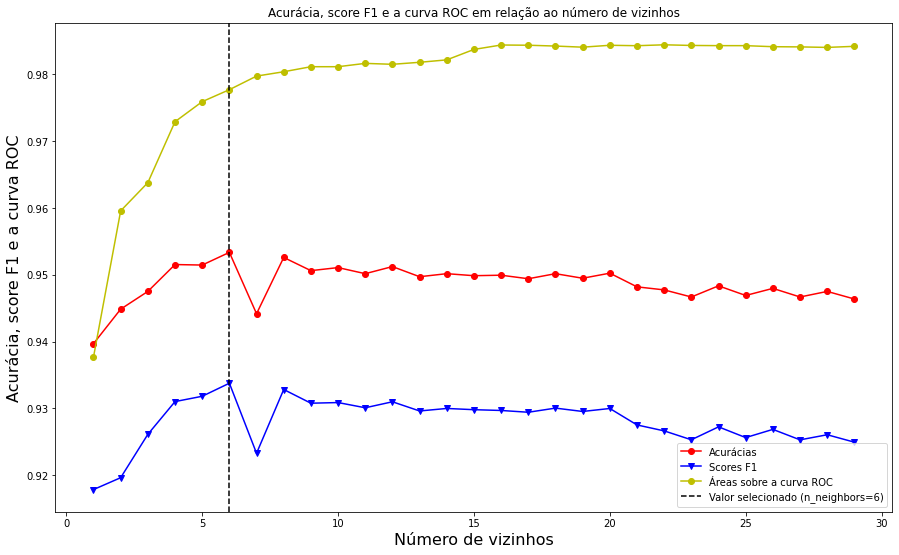

In [90]:
plt.figure(figsize=(15,9))
plt.title('Acurácia, score F1 e a curva ROC em relação ao número de vizinhos')
plt.plot(num_of_neigbors, accuracies, 'ro-',  num_of_neigbors, f1s ,'bv-', num_of_neigbors, aucs,'yo-')
plt.axvline(x=6, color='k', linestyle='--')
plt.legend(['Acurácias','Scores F1','Áreas sobre a curva ROC', 'Valor selecionado (n_neighbors=6)'])
plt.xlabel('Número de vizinhos', fontsize=16)
plt.ylabel('Acurácia, score F1 e a curva ROC', fontsize=16)
plt.show()

In [91]:
from sklearn.model_selection import GridSearchCV

# Cria um novo modelo KNN
knn_model_gscv = KNeighborsClassifier(metric='minkowski', p=2)

# Cria um dicionario com todos os parâmetros
param_grid = {'n_neighbors': np.arange(1, 30)}
# Usa o gridsearch para checar todos os valores dos vizinhos
knn_gscv = GridSearchCV(knn_model_gscv, param_grid, scoring=['accuracy', 'f1', 'roc_auc'], refit='accuracy', cv=cv)
# Cria o modelo fit para os dados
knn_gscv.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])},
             refit='accuracy', scoring=['accuracy', 'f1', 'roc_auc'])

In [92]:
# Verifica a performance dos parametros encontrados
knn_gscv.best_params_

{'n_neighbors': 6}

In [93]:
knn_gscv.best_score_

0.95334190039127

O número de vizinhos (num_neighbour) foi definido como 6 para um melhor desfecho.

In [94]:
# Avaliação do modelo no dataset de treino
y_predict = knn_gscv.predict(X)

In [95]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('Avaliação do dataset de treino')
print('Acurácia:', round(accuracy_score(y, y_predict), 3))
print('Precisão:', round(precision_score(y, y_predict), 3))
print('Recall:', round(recall_score(y, y_predict), 3))
print('Score F1:', round(f1_score(y, y_predict), 3))

Avaliação do dataset de treino
Acurácia: 0.956
Precisão: 0.956
Recall: 0.921
Score F1: 0.938


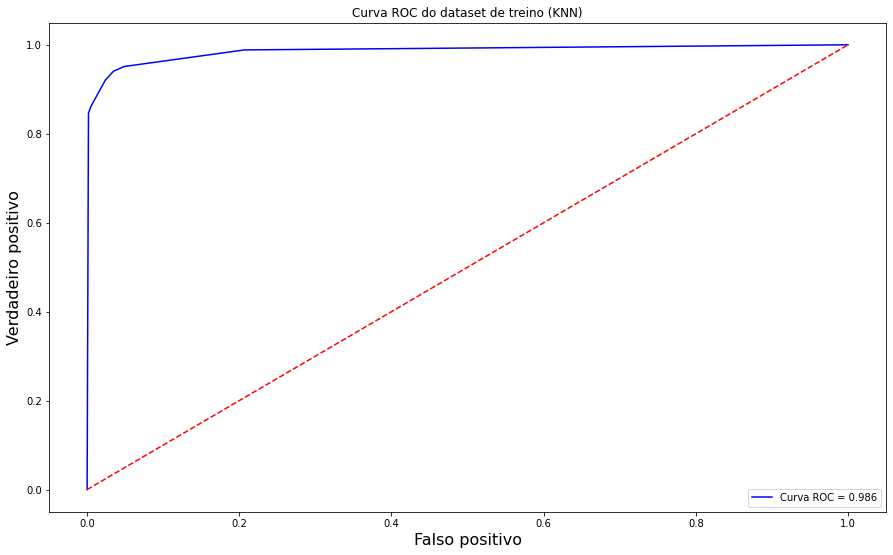

In [96]:
from sklearn.metrics import roc_curve, roc_auc_score

y_probs = knn_gscv.predict_proba(X)
y_probs = y_probs[:,1]
fpr, tpr, threshold = roc_curve(y, y_probs)
roc_auc = roc_auc_score(y, y_probs)

plt.figure(figsize =(15,9))
plt.title('Curva ROC do dataset de treino (KNN)')
plt.plot(fpr, tpr, 'b', label = 'Curva ROC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('Verdadeiro positivo', fontsize=16)
plt.xlabel('Falso positivo', fontsize=16)
plt.show()

In [97]:
# Avaliação do modelo no dataset de teste
holdout_df = pd.read_csv('https://raw.githubusercontent.com/lucaspeferreira/data-dataset/main/Drebin-Malgenome-Test-30-Features-Selecionadas.csv')
holdout_df.shape

(5649, 28)

In [98]:
holdout_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5649 entries, 0 to 5648
Data columns (total 28 columns):
 #   Column                                Non-Null Count  Dtype
---  ------                                --------------  -----
 0   transact                              5649 non-null   int64
 1   onServiceConnected                    5649 non-null   int64
 2   bindService                           5649 non-null   int64
 3   attachInterface                       5649 non-null   int64
 4   SEND_SMS                              5649 non-null   int64
 5   Ljava.lang.Class.getCanonicalName     5649 non-null   int64
 6   Ljava.lang.Class.getMethods           5649 non-null   int64
 7   Ljava.net.URLDecoder                  5649 non-null   int64
 8   android.telephony.SmsManager          5649 non-null   int64
 9   READ_PHONE_STATE                      5649 non-null   int64
 10  getBinder                             5649 non-null   int64
 11  GET_ACCOUNTS                          5649 

In [99]:
X_holdout = holdout_df.drop('class', axis = 1)
y_holdout = holdout_df['class']

In [100]:
y_holdout_predict = knn_gscv.predict(X_holdout)

In [101]:
print('Avaliação do dataset de teste')
print('Acurácia:', round(accuracy_score(y_holdout, y_holdout_predict), 3))
print('Precisão:', round(precision_score(y_holdout, y_holdout_predict), 3))
print('Recall:', round(recall_score(y_holdout, y_holdout_predict), 3))
print('Score F1:', round(f1_score(y_holdout, y_holdout_predict), 3))

Avaliação do dataset de teste
Acurácia: 0.957
Precisão: 0.953
Recall: 0.926
Score F1: 0.939


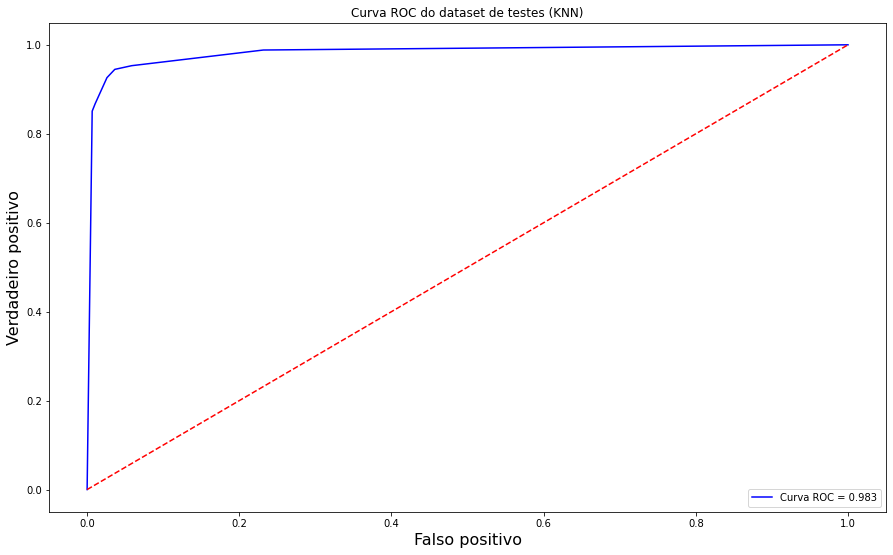

In [102]:
from sklearn.metrics import roc_curve, roc_auc_score

y_holdout_probs = knn_gscv.predict_proba(X_holdout)
y_holdout_probs = y_holdout_probs[:,1]
fpr, tpr, threshold = roc_curve(y_holdout, y_holdout_probs)
roc_auc = roc_auc_score(y_holdout, y_holdout_probs)

plt.figure(figsize =(15,9))
plt.title('Curva ROC do dataset de testes (KNN)')
plt.plot(fpr, tpr, 'b', label = 'Curva ROC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('Verdadeiro positivo', fontsize=16)
plt.xlabel('Falso positivo', fontsize=16)
plt.show()

### Linear SVM

In [103]:
from sklearn.svm import SVC

In [104]:
df = pd.read_csv('https://raw.githubusercontent.com/lucaspeferreira/data-dataset/main/Drebin-Malgenome-Train-70-Features-Selecionadas.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13181 entries, 0 to 13180
Data columns (total 28 columns):
 #   Column                                Non-Null Count  Dtype
---  ------                                --------------  -----
 0   transact                              13181 non-null  int64
 1   onServiceConnected                    13181 non-null  int64
 2   bindService                           13181 non-null  int64
 3   attachInterface                       13181 non-null  int64
 4   SEND_SMS                              13181 non-null  int64
 5   Ljava.lang.Class.getCanonicalName     13181 non-null  int64
 6   Ljava.lang.Class.getMethods           13181 non-null  int64
 7   Ljava.net.URLDecoder                  13181 non-null  int64
 8   android.telephony.SmsManager          13181 non-null  int64
 9   READ_PHONE_STATE                      13181 non-null  int64
 10  getBinder                             13181 non-null  int64
 11  GET_ACCOUNTS                          131

In [105]:
X = df.drop('class', axis = 1)
y = df['class']

In [106]:
from sklearn.model_selection import StratifiedKFold,cross_val_score

cv = StratifiedKFold(n_splits=10, random_state=42, shuffle= True)

svm_c_vals = [x for x in range(1,30)]

accuracies = []
f1s = []
aucs = []
for c_val in svm_c_vals:
    model = SVC(C=c_val, kernel='linear') #LinearSVC(C=c_val, loss="hinge", max_iter=10000, random_state=42)
    accuracie_segments = cross_val_score(model, X, y, scoring='accuracy',cv=cv, n_jobs=-1)
    f1_segments = cross_val_score(model, X, y, scoring='f1',cv=cv, n_jobs=-1)
    auc_segments = cross_val_score(model, X, y, scoring='roc_auc',cv=cv, n_jobs=-1)
    accuracies.append(np.mean(accuracie_segments))
    f1s.append(np.mean(f1_segments))
    aucs.append(np.mean(auc_segments))

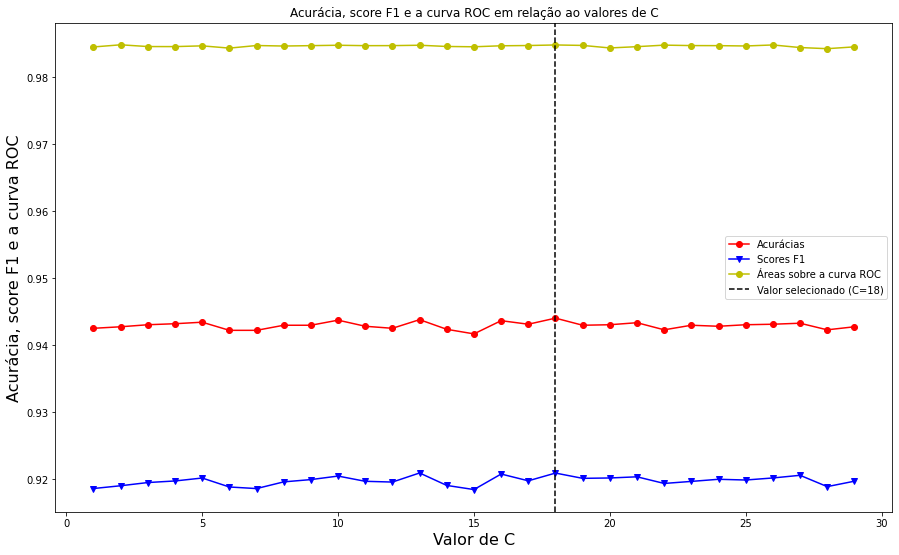

In [107]:
plt.figure(figsize =(15,9))
plt.title('Acurácia, score F1 e a curva ROC em relação ao valores de C')
plt.plot(svm_c_vals, accuracies, 'ro-', svm_c_vals, f1s ,'bv-', svm_c_vals, aucs,'yo-')
plt.axvline(x=18, color='k', linestyle='--')
plt.legend(['Acurácias','Scores F1','Áreas sobre a curva ROC', 'Valor selecionado (C=18)'])
plt.xlabel('Valor de C', fontsize=16)
plt.ylabel('Acurácia, score F1 e a curva ROC', fontsize=16)
plt.show()

In [108]:
from sklearn.model_selection import GridSearchCV

# Cria um novo modelo SVC linear
linearSVM_model_gscv = SVC(kernel='linear', probability=True)

# Cria um dicionario com todos os parâmetros
param_grid = {'C': np.arange(1, 30)}
# Usa o gridsearch para checar todos os valores do param_grid
linearSVM_gscv = GridSearchCV(linearSVM_model_gscv, param_grid, scoring=['accuracy', 'f1', 'roc_auc'], refit='accuracy', cv=cv)
# Cria o modelo fit para os dados
linearSVM_gscv.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=SVC(kernel='linear', probability=True),
             param_grid={'C': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])},
             refit='accuracy', scoring=['accuracy', 'f1', 'roc_auc'])

In [109]:
# Verifica a performance dos parametros encontrados
linearSVM_gscv.best_params_

{'C': 18}

In [110]:
linearSVM_gscv.best_score_

0.9440096362144954

In [111]:
# Avaliação do modelo no dataset de treino
y_predict = linearSVM_gscv.predict(X)

In [112]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('Avaliação do dataset de treino')
print('Acurácia:', round(accuracy_score(y, y_predict), 3))
print('Precisão:', round(precision_score(y, y_predict), 3))
print('Recall:', round(recall_score(y, y_predict), 3))
print('Score F1:', round(f1_score(y, y_predict), 3))

Avaliação do dataset de treino
Acurácia: 0.946
Precisão: 0.944
Recall: 0.903
Score F1: 0.923


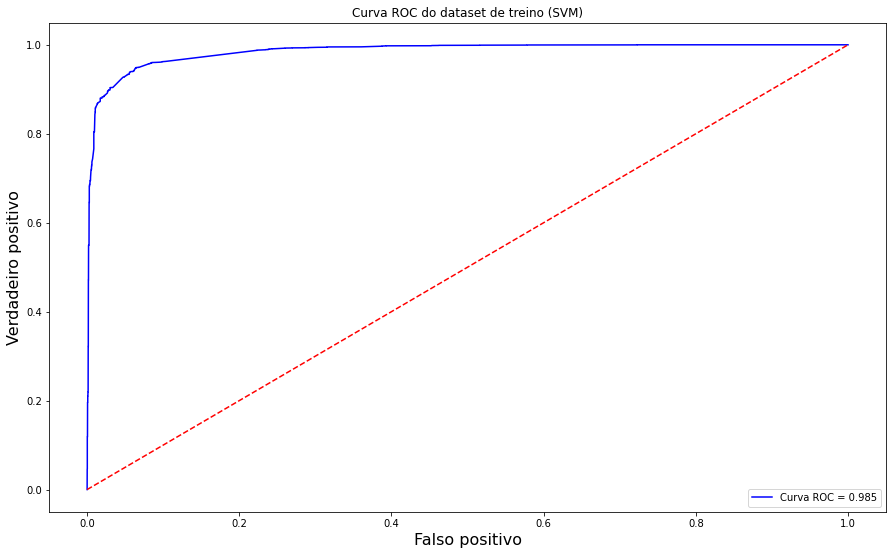

In [113]:
from sklearn.metrics import roc_curve, roc_auc_score

y_probs = linearSVM_gscv.predict_proba(X)
y_probs = y_probs[:,1]
fpr, tpr, threshold = roc_curve(y, y_probs)
roc_auc = roc_auc_score(y, y_probs)

plt.figure(figsize =(15,9))
plt.title('Curva ROC do dataset de treino (SVM)')
plt.plot(fpr, tpr, 'b', label = 'Curva ROC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('Verdadeiro positivo', fontsize=16)
plt.xlabel('Falso positivo', fontsize=16)
plt.show()

In [114]:
# Avaliação do modelo no dataset de teste
holdout_df = pd.read_csv('https://raw.githubusercontent.com/lucaspeferreira/data-dataset/main/Drebin-Malgenome-Test-30-Features-Selecionadas.csv')
holdout_df.shape

(5649, 28)

In [115]:
holdout_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5649 entries, 0 to 5648
Data columns (total 28 columns):
 #   Column                                Non-Null Count  Dtype
---  ------                                --------------  -----
 0   transact                              5649 non-null   int64
 1   onServiceConnected                    5649 non-null   int64
 2   bindService                           5649 non-null   int64
 3   attachInterface                       5649 non-null   int64
 4   SEND_SMS                              5649 non-null   int64
 5   Ljava.lang.Class.getCanonicalName     5649 non-null   int64
 6   Ljava.lang.Class.getMethods           5649 non-null   int64
 7   Ljava.net.URLDecoder                  5649 non-null   int64
 8   android.telephony.SmsManager          5649 non-null   int64
 9   READ_PHONE_STATE                      5649 non-null   int64
 10  getBinder                             5649 non-null   int64
 11  GET_ACCOUNTS                          5649 

In [116]:
X_holdout = holdout_df.drop('class', axis = 1)
y_holdout = holdout_df['class']

In [117]:
y_holdout_predict = linearSVM_gscv.predict(X_holdout)

In [118]:
print('Avaliação do dataset de teste')
print('Acurácia:', round(accuracy_score(y_holdout, y_holdout_predict), 3))
print('Precisão:', round(precision_score(y_holdout, y_holdout_predict), 3))
print('Recall:', round(recall_score(y_holdout, y_holdout_predict), 3))
print('Score F1:', round(f1_score(y_holdout, y_holdout_predict), 3))

Avaliação do dataset de teste
Acurácia: 0.945
Precisão: 0.934
Recall: 0.913
Score F1: 0.924


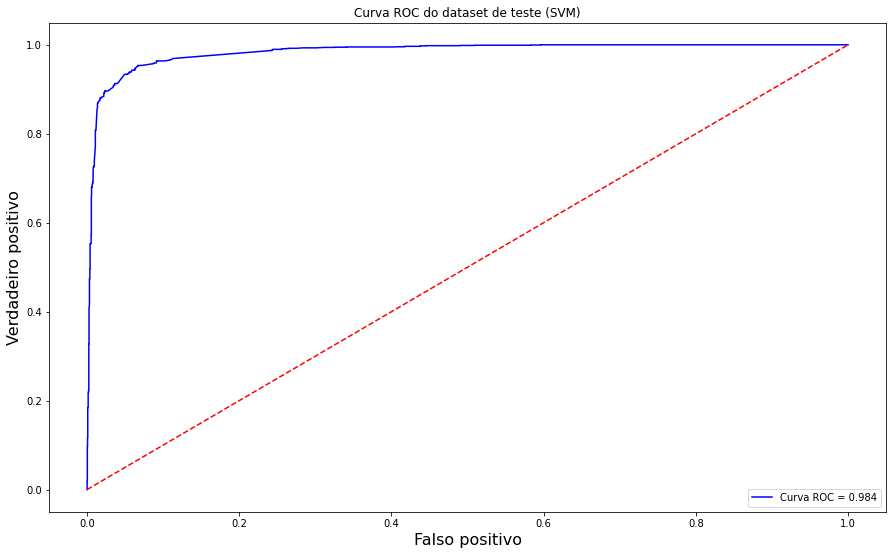

In [119]:
from sklearn.metrics import roc_curve, roc_auc_score

y_holdout_probs = linearSVM_gscv.predict_proba(X_holdout)
y_holdout_probs = y_holdout_probs[:,1]
fpr, tpr, threshold = roc_curve(y_holdout, y_holdout_probs)
roc_auc = roc_auc_score(y_holdout, y_holdout_probs)

plt.figure(figsize =(15,9))
plt.title('Curva ROC do dataset de teste (SVM)')
plt.plot(fpr, tpr, 'b', label = 'Curva ROC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('Verdadeiro positivo', fontsize=16)
plt.xlabel('Falso positivo', fontsize=16)
plt.show()

### Random Forest

In [120]:
from sklearn.ensemble import RandomForestClassifier

In [121]:
df = pd.read_csv('https://raw.githubusercontent.com/lucaspeferreira/data-dataset/main/Drebin-Malgenome-Train-70-Features-Selecionadas.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13181 entries, 0 to 13180
Data columns (total 28 columns):
 #   Column                                Non-Null Count  Dtype
---  ------                                --------------  -----
 0   transact                              13181 non-null  int64
 1   onServiceConnected                    13181 non-null  int64
 2   bindService                           13181 non-null  int64
 3   attachInterface                       13181 non-null  int64
 4   SEND_SMS                              13181 non-null  int64
 5   Ljava.lang.Class.getCanonicalName     13181 non-null  int64
 6   Ljava.lang.Class.getMethods           13181 non-null  int64
 7   Ljava.net.URLDecoder                  13181 non-null  int64
 8   android.telephony.SmsManager          13181 non-null  int64
 9   READ_PHONE_STATE                      13181 non-null  int64
 10  getBinder                             13181 non-null  int64
 11  GET_ACCOUNTS                          131

In [122]:
X = df.drop('class', axis = 1)
y = df['class']

In [123]:
from sklearn.model_selection import StratifiedKFold,cross_val_score

cv = StratifiedKFold(n_splits=10, random_state=42, shuffle= True)

num_trees = [x for x in range(1,50)]

accuracies = []
f1s = []
aucs = []
for tree_num in num_trees:
    model = RandomForestClassifier(n_estimators=tree_num, max_features='log2', random_state=42)
    accuracie_segments = cross_val_score(model, X, y, scoring = 'accuracy',cv = cv, n_jobs = 1)
    f1_segments = cross_val_score(model, X, y, scoring = 'f1',cv = cv, n_jobs = 1)
    auc_segments = cross_val_score(model, X, y, scoring = 'roc_auc',cv = cv, n_jobs = 1)
    accuracies.append(np.mean(accuracie_segments))
    f1s.append(np.mean(f1_segments))
    aucs.append(np.mean(auc_segments))

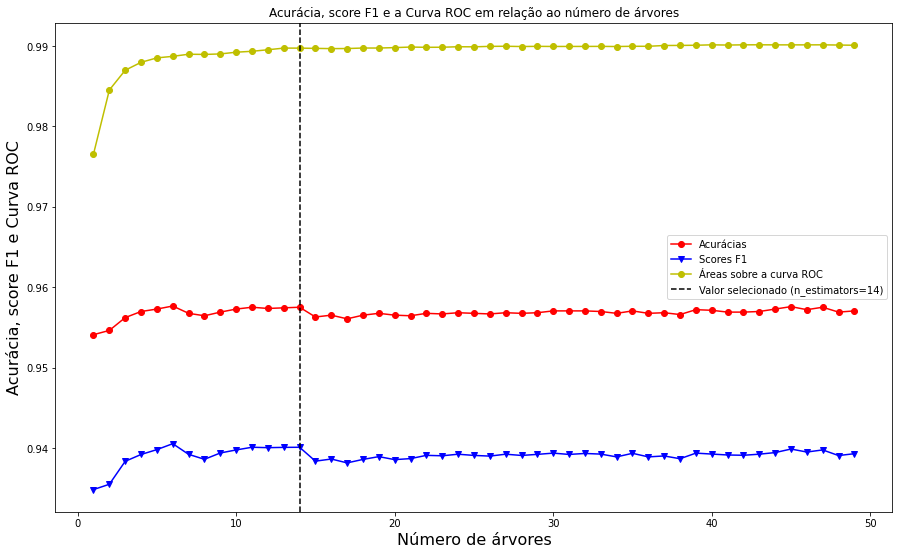

In [124]:
plt.figure(figsize =(15,9))
plt.title('Acurácia, score F1 e a Curva ROC em relação ao número de árvores')
plt.plot(num_trees, accuracies, 'ro-', num_trees, f1s ,'bv-', num_trees, aucs,'yo-')
plt.axvline(x=14, color='k', linestyle='--')
plt.legend(['Acurácias','Scores F1','Áreas sobre a curva ROC', 'Valor selecionado (n_estimators=14)'])
plt.xlabel('Número de árvores', fontsize=16)
plt.ylabel('Acurácia, score F1 e Curva ROC', fontsize=16)
plt.show()

In [125]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': np.arange(1, 50), 'max_features': ['log2', 'sqrt', 0.5]}

rf = RandomForestClassifier(random_state=42)

randomForest_gscv = GridSearchCV(rf, param_grid, cv = cv, scoring=['accuracy', 'f1', 'roc_auc'], refit='accuracy', n_jobs = -1)
randomForest_gscv.fit(X,y)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_features': ['log2', 'sqrt', 0.5],
                         'n_estimators': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
             refit='accuracy', scoring=['accuracy', 'f1', 'roc_auc'])

In [126]:
randomForest_gscv.best_params_

{'max_features': 'sqrt', 'n_estimators': 14}

In [127]:
y_predict = randomForest_gscv.predict(X)

In [128]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('Avaliação do dataset de teste')
print('Acurácia:', round(accuracy_score(y, y_predict), 3))
print('Precisão:', round(precision_score(y, y_predict), 3))
print('Recall:', round(recall_score(y, y_predict), 3))
print('Score F1:', round(f1_score(y, y_predict), 3))

Avaliação do dataset de teste
Acurácia: 0.965
Precisão: 0.96
Recall: 0.942
Score F1: 0.951


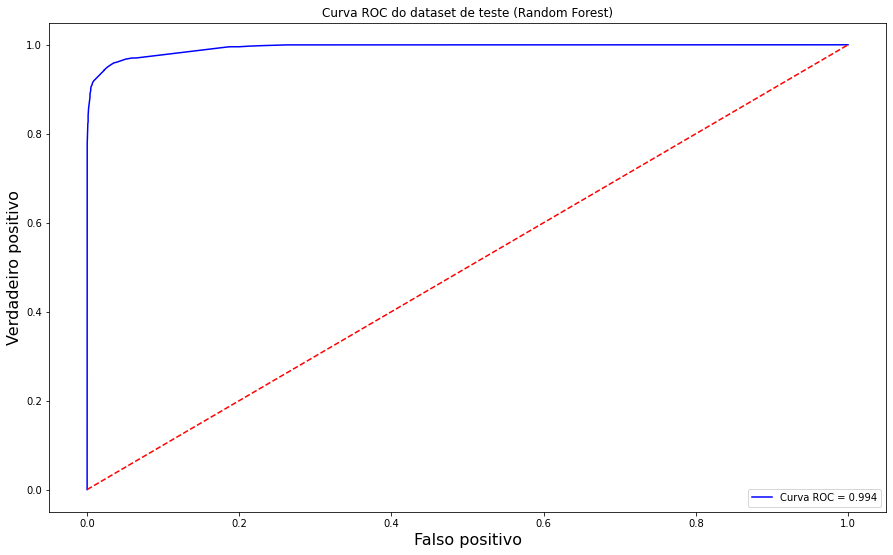

In [129]:
from sklearn.metrics import roc_curve, roc_auc_score

y_probs = randomForest_gscv.predict_proba(X)
y_probs = y_probs[:,1]
fpr, tpr, threshold = roc_curve(y, y_probs)
roc_auc = roc_auc_score(y, y_probs)

plt.figure(figsize =(15,9))
plt.title('Curva ROC do dataset de teste (Random Forest)')
plt.plot(fpr, tpr, 'b', label = 'Curva ROC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('Verdadeiro positivo', fontsize=16)
plt.xlabel('Falso positivo', fontsize=16)
plt.show()

In [130]:
# Avaliação do modelo no dataset de teste
holdout_df = pd.read_csv('https://raw.githubusercontent.com/lucaspeferreira/data-dataset/main/Drebin-Malgenome-Test-30-Features-Selecionadas.csv')
holdout_df.shape

(5649, 28)

In [131]:
holdout_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5649 entries, 0 to 5648
Data columns (total 28 columns):
 #   Column                                Non-Null Count  Dtype
---  ------                                --------------  -----
 0   transact                              5649 non-null   int64
 1   onServiceConnected                    5649 non-null   int64
 2   bindService                           5649 non-null   int64
 3   attachInterface                       5649 non-null   int64
 4   SEND_SMS                              5649 non-null   int64
 5   Ljava.lang.Class.getCanonicalName     5649 non-null   int64
 6   Ljava.lang.Class.getMethods           5649 non-null   int64
 7   Ljava.net.URLDecoder                  5649 non-null   int64
 8   android.telephony.SmsManager          5649 non-null   int64
 9   READ_PHONE_STATE                      5649 non-null   int64
 10  getBinder                             5649 non-null   int64
 11  GET_ACCOUNTS                          5649 

In [132]:
X_holdout = holdout_df.drop('class', axis = 1)
y_holdout = holdout_df['class']

In [133]:
y_holdout_predict = randomForest_gscv.predict(X_holdout)

In [134]:
print('Avaliação do dataset de treino')
print('Acurácia:', round(accuracy_score(y_holdout, y_holdout_predict), 3))
print('Precisão:', round(precision_score(y_holdout, y_holdout_predict), 3))
print('Recall:', round(recall_score(y_holdout, y_holdout_predict), 3))
print('Score F1:', round(f1_score(y_holdout, y_holdout_predict), 3))

Avaliação do dataset de treino
Acurácia: 0.962
Precisão: 0.952
Recall: 0.944
Score F1: 0.948


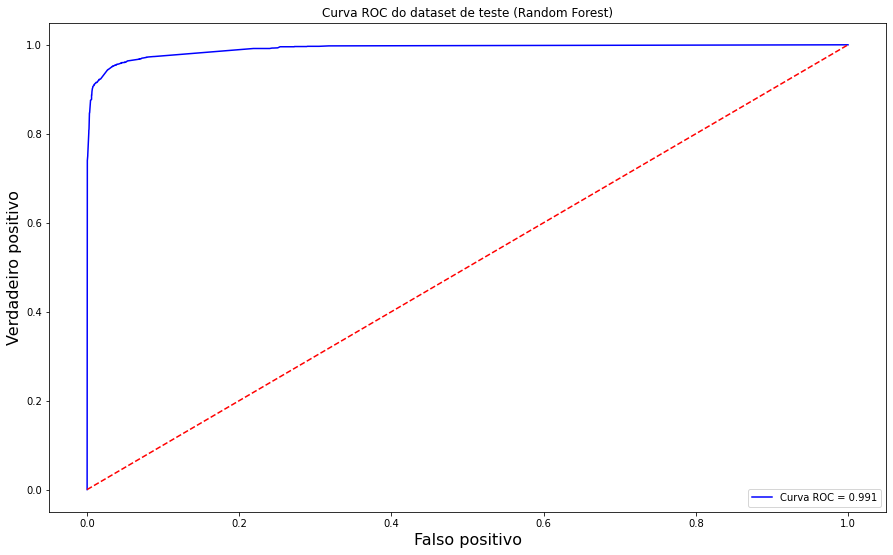

In [135]:
from sklearn.metrics import roc_curve, roc_auc_score

y_holdout_probs = randomForest_gscv.predict_proba(X_holdout)
y_holdout_probs = y_holdout_probs[:,1]
fpr, tpr, threshold = roc_curve(y_holdout, y_holdout_probs)
roc_auc = roc_auc_score(y_holdout, y_holdout_probs)

plt.figure(figsize =(15,9))
plt.title('Curva ROC do dataset de teste (Random Forest)')
plt.plot(fpr, tpr, 'b', label = 'Curva ROC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('Verdadeiro positivo', fontsize=16)
plt.xlabel('Falso positivo', fontsize=16)
plt.show()